In [1]:
import pandas as pd
import prince
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve
import xgboost as xgb

###### Assumption 1 - Missing lab values are normal = 0
###### Problem 1 - Some zipcodes are from Hawaii. Distance is very high.

In [2]:
X_cont = pd.read_csv('ContinuousTrainData.csv')
X = X_cont.copy()

In [3]:
# Drop rows with missing charge data
X.dropna(subset=['CHARGE_FLAG_85pctile'], inplace=True)
Y = X.CHARGE_FLAG_85pctile

# continuous:
X.drop(['ANNUAL_AVG_CHARGE', 'CHARGE_FLAG_85pctile', 'AUTO_ID', 'PAT_ID', 'PAT_MRN_ID'], axis=1, inplace=True)


In [4]:
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=0.33, random_state=3)

# XGBOOST

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [int(x) for x in np.linspace(40, 60, num = 3)],
               'min_child_weight': [2],
               'max_depth': [2, 5, 10],
               'reg_lambda': [2, 4],
               'scale_pos_weight': [2, 3],
               'colsample_bytree':[0.2, 0.3, 0.4]}

grid = GridSearchCV(xgb.XGBClassifier(learning_rate=0.1), param_grid, return_train_score=True,  n_jobs = -1)
grid.fit(xtr, ytr)
winner = grid.best_estimator_
winner

D:\MiscSoftware\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [6]:
winner = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=2, seed=None,
       silent=True, subsample=1).fit(xtr, ytr)

In [7]:
print("Train Score: ", winner.score(xtr,ytr))
print("Test Score: ", winner.score(xte, yte))
print("AUC: ", roc_auc_score(yte, winner.predict(xte)))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(xte)))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))
print("\n\n",sorted(list(zip(X.columns, winner.feature_importances_)), key=lambda x:x[1], reverse=True))

Train Score:  0.9762258543833581
Test Score:  0.8914572864321608
AUC:  0.7443279020711877
ConfMat: 
 [[811  43]
 [ 65  76]]
Train Label_Count:  [1708  311]
Test Label_Count:  [854 141]


 [('ALBUMIN_HIGH_SCORE', 0.10815363), ('HEMO_HIGH_SCORE', 0.08279637), ('AVG_ANNUAL_ENC_CONSULT', 0.081065156), ('EOS_HIGH_SCORE', 0.046993885), ('ESR_HIGH_SCORE', 0.04283266), ('CRP_HIGH_SCORE', 0.042125076), ('AVG_ANNUAL_ENC_OFF', 0.03718228), ('AVG_ANNUAL_ENC_TEL', 0.03189504), ('PSYCH_DURATION_YEARS', 0.029099943), ('Vitamin_D_DURATION_YEARS', 0.025785286), ('Systemic_steroids_ANNUAL_AVG_DOSAGE', 0.02421084), ('MONO_HIGH_SCORE', 0.023963954), ('AVG_ANNUAL_ENC_PROC', 0.023834275), ('EMPLOYMENT_STATUS', 0.0233849), ('TOBACCO_USE', 0.021871703), ('Immunomodulators_ANNUAL_AVG_DOSAGE', 0.021582553), ('AVG_SIBDQ_SCORE', 0.020620871), ('CHARGE_DURATION_YRS', 0.02038896), ('VITD_HIGH_SCORE', 0.020301253), ('Vitamin_D_ANNUAL_AVG_DOSAGE', 0.019100077), ('ANTIBIOTICS_ANNUAL_AVG_DOSAGE', 0.017787661), ('PSYCH_

In [ ]:
import pickle
with open('XGB_Continuous.pickle', 'wb') as f:
    pickle.dump(winner, f)

In [8]:
misclassified = X_cont.ix[xte.index].copy()
# misclassified['CHARGE'] = X_cont.ix[misclassified.index]['ANNUAL_AVG_CHARGE']
misclassified['y_true'] = yte
misclassified['y_pred'] = winner.predict(xte)
misclassified['predict_proba'] = winner.predict_proba(xte)[:,1]
misclassified['confidence'] = list(map(max, winner.predict_proba(xte)))

D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [9]:
calib = misclassified[['y_true', 'y_pred', 'predict_proba', 'confidence']]
bins = np.arange(0,1.1,0.1)
calib['bin'] = pd.cut(calib.predict_proba, bins)
calib['correct'] = np.where(calib.y_true==calib.y_pred, 1, 0)
calib[['y_true0', 'y_true1']] = pd.get_dummies(calib.y_true)
calib2 = pd.DataFrame()
calib2['bincount'] = calib.groupby('bin').y_pred.count()
calib2['acc'] = calib.groupby('bin').correct.mean()
calib2['prevalence1_obs'] = calib.groupby('bin').y_true1.sum()/calib2.bincount
calib2['prevalence0_obs'] = calib.groupby('bin').y_true0.sum()/calib2.bincount
calib2 ['binR'] = bins[1:]
calib2

D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\MiscSoftware\Anaconda\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,bincount,acc,prevalence1_obs,prevalence0_obs,binR
bin,,,,,
"(0.0, 0.1]",628,0.984076,0.015924,0.984076,0.1
"(0.1, 0.2]",109,0.853211,0.146789,0.853211,0.2
"(0.2, 0.3]",57,0.771930,0.228070,0.771930,0.3
"(0.3, 0.4]",45,0.733333,0.266667,0.733333,0.4
"(0.4, 0.5]",37,0.621622,0.378378,0.621622,0.5
"(0.5, 0.6]",26,0.461538,0.461538,0.538462,0.6
"(0.6, 0.7]",27,0.407407,0.407407,0.592593,0.7
"(0.7, 0.8]",26,0.769231,0.769231,0.230769,0.8
"(0.8, 0.9]",27,0.740741,0.740741,0.259259,0.9


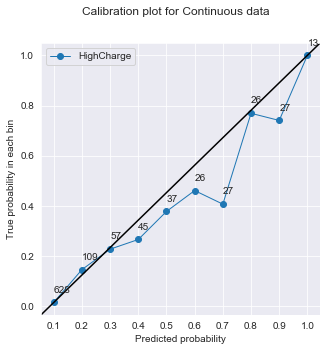

In [17]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(calib2['binR'], calib2['prevalence1_obs'], marker='o', linewidth=1, label='HighCharge')
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Continuous data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.xaxis.set_ticks(calib2['binR'])

for _,row in calib2.iterrows():
    ax.annotate(int(row['bincount']), (row['binR'], row['prevalence1_obs']+0.04))
    
plt.legend()
plt.show()

In [ ]:
with pd.ExcelWriter('XGBoostAnalysis_CDUC.xlsx') as writer:  # doctest: +SKIP
    misclassified.to_excel(writer, sheet_
                           name='ALL_PRED')
    misclassified.sort_values(by='SIBDQ', ascending=True).head(20).to_excel(writer, sheet_name='TOP20_LOW_SIBDQ')
    misclassified.sort_values(by='CHARGE', ascending=False).head(20).to_excel(writer, sheet_name='TOP20_HIGH_CHARGE')
    misclassified[misclassified.y_true==misclassified.y_pred].to_excel(writer, sheet_name='CORRECT_PREDS')
    misclassified[misclassified.y_true!=misclassified.y_pred].to_excel(writer, sheet_name='WRONG_PREDS')

In [ ]:
confident_preds = misclassified[misclassified.confidence>=0.7]
confident_preds[confident_preds.y_true==confident_preds.y_pred].shape[0]/confident_preds.shape[0]

In [ ]:
confident_preds.shape[0]

# SVM

In [ ]:
X_SVM = X.copy()
X_SVM.drop(['AVG_SIBDQ_SCORE','PSYCH_DX'], axis=1, inplace=True)
X_SVM.dropna(subset=['PSYCH_DURATION_YEARS'], inplace=True)
X_SVM.fillna(0, inplace=True)

In [ ]:
Y_SVM = Y[X_SVM.index]
xtr, xte, ytr, yte = train_test_split(X_SVM, Y_SVM, test_size=0.33, random_state=3)

In [ ]:
scaler = StandardScaler().fit(xtr)

kfold=5
results = []
for c in [5, 8, 12]:
    for gamma in [0.01, 0.05, 0.1]:
        scores = cross_val_score(SVC(C=c, gamma=gamma), scaler.transform(xtr), ytr, cv=kfold)
        mean_score = np.mean(scores)
        results.append((c, gamma, mean_score))

best_c, best_gamma, best_score = max(results, key=lambda tup:tup[2])
winner = SVC(C=best_c, gamma=best_gamma).fit(scaler.transform(xtr), ytr)



In [ ]:
print("Train Score: ", best_score)
print("Test Score: ", winner.score(scaler.transform(xte), yte))
print("AUC: ", roc_auc_score(yte, winner.predict(scaler.transform(xte))))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(scaler.transform(xte))))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))

# RF

In [ ]:
# Number of features to consider at every split
max_features = [10, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(60, 100, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(90, 150, num = 3)],
               'max_features': max_features,
               'max_depth': [5,10],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':['balanced', 'balanced_subsample']}
rf_gridsearch = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_gridsearch.fit(xtr, ytr)

In [ ]:
winner = rf_gridsearch.best_estimator_
print("Best estimator: \n",winner)
print("Train Score: ", winner.score(xtr,ytr))
print("Test Score: ", winner.score(xte, yte))
print("AUC: ", roc_auc_score(yte, winner.predict(xte)))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(xte)))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))
print("\n\n",sorted(list(zip(X.columns, winner.feature_importances_)), key=lambda x:x[1], reverse=True))